In [1]:
import sqlite3
import csv
import os
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('encounters.db')
cursor = conn.cursor()

# Get the list of tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

# Export each table to a separate CSV file
for table in tables:
    table_name = table[0]
    csv_file_path = f'{table_name}.csv'
    
    # Execute a query to select all data from the table
    cursor.execute(f'SELECT * FROM {table_name}')
    rows = cursor.fetchall()
    
    # Write data to the CSV file
    # Certain characters break if not UTF-8 enocoded, might be the korean?
    with open(csv_file_path, 'w',encoding="utf-8", newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([description[0] for description in cursor.description])
        csvwriter.writerows(rows)

    print(f"Exported table '{table_name}' to '{csv_file_path}'")

conn.close()

Exported table 'encounter' to 'encounter.csv'
Exported table 'entity' to 'entity.csv'


In [2]:
def remove_junk_names(df):
    ''' not sure why this occurs but to remove non player names that get in there run this over the death df'''
    df = df[df['name'].str.contains('\d') == False]
    return df

entity_df = pd.read_csv('entity.csv')
entity_df = remove_junk_names(entity_df)
encounter_df = pd.read_csv('encounter.csv')

In [3]:
# Grab the boss in question and only look at the players
one_boss_all_encounters = entity_df[entity_df['name']=='Thaemine the Lightqueller']
one_boss_all_encounters = entity_df[entity_df['encounter_id'].isin(one_boss_all_encounters['encounter_id'])]
players = one_boss_all_encounters[one_boss_all_encounters['entity_type'] == 'PLAYER']

# The combat details are under damage_stats so to merge them back in we reset the index then concat them together.
# there is a lot of worthless columns here so maybe remove those later idc
players.reset_index(drop=True,inplace=True)
from pandas import json_normalize
damage_stats = json_normalize(players['damage_stats'].apply(eval))
players_full_detail = pd.concat([players,damage_stats], axis = 1)
# Get death information

# we just care about deaths for this
player_data_clean = players_full_detail[['name','encounter_id','deathTime']]

# If someone doesn't die the deathtime = 0 so to make it so it doesn't look like they die first I am setting the death time for them to 9999999999999
player_data_clean.loc[player_data_clean['deathTime'] == 0, 'deathTime'] = 9999999999999

# Use when you want to see all the columns
# players.columns.tolist()

In [4]:
# filter out the people who live until restart
encounter_death_info = encounter_df[['id','last_combat_packet','fight_start','duration']]
encounter_death_info = encounter_death_info.rename(columns = {'id':'encounter_id',
                                        'last_combat_packet' :'last_combat_packet',
                                        'fight_start' : 'fight_start',
                                        'duration' : 'duration'})

# Remove deaths from restarts and kill pulls
removed_deaths = player_data_clean.merge(encounter_death_info,on='encounter_id',how='left')
# 1000 = 1 seconds in unix epoch time
removed_deaths = removed_deaths[removed_deaths['deathTime'] <= (removed_deaths['last_combat_packet'] - 1500)]
player_data_clean = removed_deaths[['name','encounter_id','deathTime']]

In [5]:
# removed_deaths.groupby(['encounter_id','name']).max().sort_values(by='deathTime',ascending=True).head(60)

In [6]:
def first_death_grouper(df):
    ''' Only keep the first group of players who died.'''
    # only keep the first death group
    min_deathTime = df.groupby(['encounter_id'])['deathTime'].transform('min')
    # Filter the DataFrame to include only rows where the deathTime is the smallest in the encounter_id
    first_death_group = df[df['deathTime'] == min_deathTime].groupby(['encounter_id', 'name','deathTime']).size().reset_index(name='count').drop('count',axis=1)
    # We could have added this at a prior point but I just thought of it so it is being added here.
    # This connects the encounter times, so we can remove the final deathtimes with the final combat death. Seeing how the last group of people aren't really causing the wipe we want to exclude them
    first_death_group
    return first_death_group
    
first_death_group = first_death_grouper(player_data_clean)

In [7]:
def nth_death_grouper(full_df,first_deaths_df):
    '''grab the next layer of deaths past the first group
    You can run this on the result df in a loop to drill down deeper into groups'''
    drilled_down_deaths = full_df.merge(first_deaths_df, on='deathTime', how='left', indicator=True)
    result_df = drilled_down_deaths[drilled_down_deaths['_merge'] == 'left_only'].drop(columns='_merge')
    # fix names
    result_df = result_df[['name_x','encounter_id_x','deathTime']].rename(columns={'name_x': 'name',
                                                                                     'encounter_id_x' : 'encounter_id',
                                                                                     'deathTime': 'deathTime'})
    return result_df

second_group_deaths_df = nth_death_grouper(player_data_clean,first_death_group)

In [8]:
# add in a custom metric for prog and 1st reclear
prog_data = player_data_clean[player_data_clean['encounter_id'] < 510]
reclear_data = player_data_clean[player_data_clean['encounter_id'] >= 510]


In [9]:
# Group deaths and remove junk names
def parse_first_second_groups(df):
    first_group_df = remove_junk_names(first_death_grouper(df))
    second_group_df = remove_junk_names(nth_death_grouper(df,first_group_df))
    
    first_group_df = first_group_df.groupby(['name']).count().reset_index()
    second_group_df = second_group_df.groupby(['name']).count().reset_index()
    
    merged_group = first_group_df.merge(second_group_df, on='name', how='left').drop(['deathTime_x','deathTime_y'],axis=1)
    merged_group = merged_group.rename(columns={'name':'name',
                               'encounter_id_x' : 'first_death_group_count',
                                'encounter_id_y' : 'second_death_group_count'
                               })
    return merged_group

In [10]:
# Performance Logs
prog_results = parse_first_second_groups(prog_data)
reclear_results = parse_first_second_groups(reclear_data)

# Chickenwings was broken for the reclear data manually adding back in
chicken_reclear_row_fix = {'name': 'Chickenwings' ,
'first_death_group_count': 0,
 'second_death_group_count': 2 
}

reclear_results = pd.concat([reclear_results,pd.DataFrame([chicken_reclear_row_fix])], ignore_index=True)

In [11]:
# reclear_results

In [12]:
# prog_results.sort_values('first_death_group_count',ascending=False)

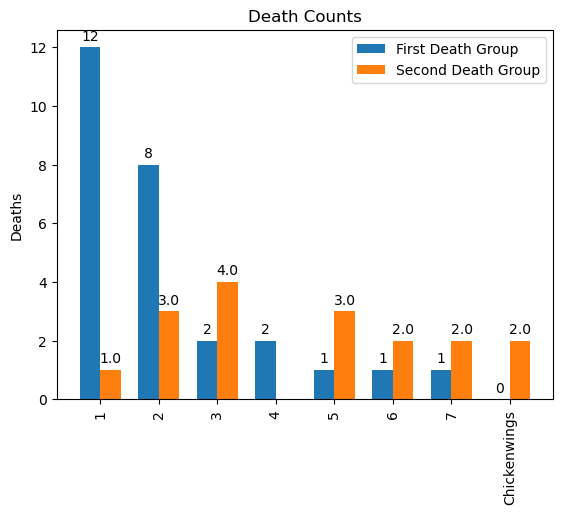

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import json

plot_df = reclear_results.sort_values('first_death_group_count',ascending=False)

# Plotting
fig, ax = plt.subplots()
width = 0.35
x = range(len(plot_df))

bars1 = ax.bar(x, plot_df['first_death_group_count'], width, label='First Death Group')
bars2 = ax.bar([i + width for i in x], plot_df['second_death_group_count'], width, label='Second Death Group')

ax.set_ylabel('Deaths')
ax.set_title('Death Counts')
ax.set_xticks([i + width/2 for i in x])
# for everyones name
# ax.set_xticklabels(plot_df['name'], rotation=90)  # Rotate x-axis labels 90 degrees
ax.set_xticklabels([1,2,3,4,5,6,7,'Chickenwings'], rotation=90)  # Rotate x-axis labels 90 degrees
ax.legend()

# Attach labels
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.show()


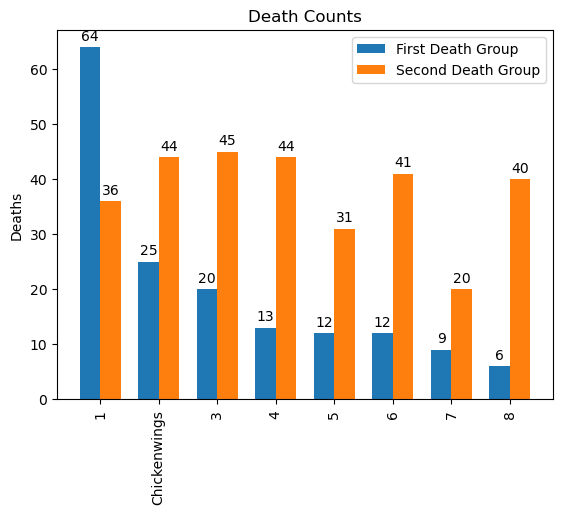

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import json

plot_df = prog_results.sort_values('first_death_group_count',ascending=False)

# Plotting
fig, ax = plt.subplots()
width = 0.35
x = range(len(plot_df))

bars1 = ax.bar(x, plot_df['first_death_group_count'], width, label='First Death Group')
bars2 = ax.bar([i + width for i in x], plot_df['second_death_group_count'], width, label='Second Death Group')

ax.set_ylabel('Deaths')
ax.set_title('Death Counts')
ax.set_xticks([i + width/2 for i in x])
# for everyones name
# ax.set_xticklabels(plot_df['name'], rotation=90)  # Rotate x-axis labels 90 degrees
ax.set_xticklabels([1,'Chickenwings',3,4,5,6,7,8], rotation=90)  # Rotate x-axis labels 90 degrees
ax.legend()

# Attach labels
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.show()


In [15]:
prog_results.loc[prog_results['name'] == 'Chickenwings','name'] = 'prog'
reclear_results.loc[reclear_results['name'] == 'Chickenwings','name'] = 'reclear'
mergered_single = prog_results.merge(reclear_results,on='name',how='outer')
mergered_single = mergered_single[mergered_single['name'].str.contains('prog|reclear')]
# removing 1 for clear pull
mergered_single['total_pulls'] = [(prog_data['encounter_id'].nunique() - 1),(reclear_data['encounter_id'].nunique()-1)]

In [16]:
# Move the Y data to the X location then dump the Y columns
mergered_single.loc[mergered_single['name'] == 'reclear','first_death_group_count_x'] = mergered_single.loc[mergered_single['name'] == 'reclear','first_death_group_count_y'] 
mergered_single.loc[mergered_single['name'] == 'reclear','second_death_group_count_x'] = mergered_single.loc[mergered_single['name'] == 'reclear','second_death_group_count_y'] 
mergered_single = mergered_single[['name', 'first_death_group_count_x', 'second_death_group_count_x','total_pulls']]

# Revaluing of the columns to convert them to percentage
mergered_single['first_death_group_count_x'] = mergered_single['first_death_group_count_x']/mergered_single['total_pulls']
mergered_single['second_death_group_count_x'] = mergered_single['second_death_group_count_x']/mergered_single['total_pulls']

# Fix the column names
mergered_single = mergered_single.rename(columns={'name' : 'name',
                                'first_death_group_count_x' : 'first_death_group',
                                'second_death_group_count_x' : 'second_death_group',
                                'total_pulls' : 'total_pulls'
    
})

mergered_single = mergered_single[['name', 'first_death_group', 'second_death_group']]


In [17]:
mergered_single

,name,first_death_group,second_death_group
1,prog,0.178571,0.314286
10,reclear,0.000000,0.090909


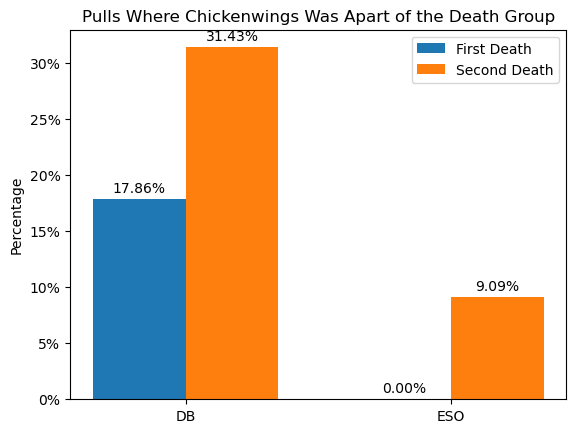

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import json

df = mergered_single

# Plotting
fig, ax = plt.subplots()
width = 0.35
x = range(len(df))

bars1 = ax.bar(x, df['first_death_group'], width, label='First Death')
bars2 = ax.bar([i + width for i in x], df['second_death_group'], width, label='Second Death')

ax.set_ylabel('Percentage')
ax.set_title('Pulls Where Chickenwings Was Apart of the Death Group')
ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(df['name'])
ax.legend()

# Format y-axis as percentages
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.set_xticklabels(['DB','ESO'])  # Rotate x-axis labels 90 degrees

# Attach labels
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2%}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.show()